# Final Assignment - Introduction to NLP

## Task and Data Analysis

#### Initial Analysis

The data supplied for the creation of this opinion miner comes in three different datasets, referred to as follows:
* Dataset A - Five *.txt* files in folder *'Customer_review_data'*;
* Dataset B - Three *.txt* files in folder *'CustomerReviews-3_domains'*;
* Dataset C - Nine *.txt* files in folder *'Reviews-9-products'*.

Datasets A and B have been used for academic publications in different papers (Hu and Liu, 2004a; Hu and Liu, 2004b; Liu *et al.*, 2015) on creating an opinion miner. While Dataset C did not come with a descriptive *Readme.txt* file, its format, tagging, and layout suggest that it derives from the same research as datasets A and B. Each of these datasets contains customer reviews for various products from amazon.com.
##### Structure
Each dataset comprises sentences from a customer review on that particular product, each of which has been preprocessed in a number of ways. In all three datasets each review sentence is prefixed by *##* to indicate the start of a new sentence. Datasets A and C separate different reviews by inserting *[t]* at the beginning, sometimes followed by a sentence for the title of that review, while Dataset B is simply a continuous list of review sentences. However, while Dataset C does use the *[t]* convention, the title text is always blank (the exception being *Speaker.txt* in Dataset C, which does begin with a *[t]* but is only a singular occurrence).
##### Labeling
As well as having each review sorted by sentence, most sentences have been manually labelled with product features extracted from the subsequent sentence. These labels are then followed by an indicator of sentiment, either positive or negative, and the numerical strength. Datasets A and C have a numerical range between 1 and 3, while Dataset B only ever uses a -1 or +1 to indicate sentiment.
In addition, all datasets can contain further labels to indicate how the product labelling was derived in order to help enhance understanding. Datasets A and C's additional labels focus on whether the product feature actually appears in the sentence or is interpreted, as well as whether the feature is a suggestion or comparison with another product. Dataset B's labels only describe whether the sentence contains adjectives or verbs from which the product feature was derived. All of these extra labels occur after the sentiment label.
##### Further differences
Some further differences between the datasets is that Dataset A appears to have had all text changed to lower case, which Datasets B and C still retain their original case formatting. Also, Datasets A and B place a space before all punctuation characters, including those which appear within contracted words (e.g. *'I'd'* becomes *'I 'd'*), while Dataset C retains the original formatting in this regard. All datasets appear to contain occasional format errors or spelling mistakes.

#### System Design
To develop this opinion miner a number of steps need to be developed through which the data is processed, key features and sentiment extracted, then all collated and presented for each product of interest. To achieve this the following general process was implemented:
* Data ingestion and sorting of all review files. This comprises the following sub-steps:
    - Extraction of features and sentiment labels to create a ground-truth dataset for later analysis, labelled by sentence number.
    - Creation of a dictionary containing all raw sentences labelled by sentence number to allow ground-truth comparison and extraction.
* Feature extraction from the raw sentences of a given product. This is done by:
    - Extracting nouns and noun chunks and combining these with frequent bigrams and trigrams into a set of features.
    - Pruning and cleaning of feature names.
* Sentiment extraction for each occurrence of a feature. Two parallel methods were created in order to determine sentiment - a rule-based algorithm and a supervised machine-learning (ML) model.
    - The rule-based approach finds features from the feature list within a sentence and extracts sentiment-bearing adjectives related to the feature.
    - The ML model trains on 80% of the reviews, after which it is used to determine the sentiment of a sentence and assigns that to any features present in that sentence.
* The features and their assigned sentiment values are then compiled for each product and presented in three plots, one each for the two different sentiment extraction methods with the third displaying the ground-truth data for comparison.


In [1]:
import os, codecs
import re
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS as stopwords_list
import difflib
import nltk
from nltk.collocations import *
from collections import Counter
from nltk.corpus import wordnet
from textblob import TextBlob
import matplotlib.pyplot as plt
import random
import math
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings

In [2]:
# variables used in the pipeline, including stopword and punctuation lists used in sentence processing.
nlp = spacy.load("en_core_web_lg")
punctuation_list = set([p for p in string.punctuation])
stop_punc_list = punctuation_list.union(stopwords_list)

# list of products for testing (and not used in the ML training dataset using seed=48).
file_name = 'Nokia 6600'
file_name1 = 'Nikon coolpix 4300'
file_name2 = 'Canon PowerShot SD500'
file_name3 = 'ipod'

## Data Preprocessing
The primary goal of the data processing step is to ingest the reviews from each file into a useful format before being passed into the pipeline. The primary data structure used throughout most of this project is the dictionary, which gives the ability to compare ground-truth data between sentences of any given product at each part of the pipeline.
#### File ingestion
Rather than just ingesting one file at a time it is more efficient to import all files together into a dictionary which could be queried by later stages of the process. This dictionary stores the raw strings as values under each product name key.
#### Ground-truth extraction
Each review dataset comes with manual labels of features and sentiment which would be needed later, not only to compare the results of the pipeline but also to assist in training the sentiment classification algorithm. Therefore, extracting it at this stage and storing it in the same dictionary structure meant no alteration of this data could occur during later processing stages. The function *get_ground_truth* stores all features and sentiment labels and returns a dictionary with the structure *{product name: {sentence number: {feature: sentiment}}}*.
#### Collate review sentences
Once ground-truth data was extracted, the main dataset for use in the pipeline could follow. This consists of the sentences for each product, extracted without the labels and sentiment. Similar to the ground-truth data, the function *get_review_sentences* returns a dictionary of *{product name: {sentence number: sentence string}}*. This allows individual product reviews to be queried and for direct comparison with the ground-truth set.
#### Processing of strings
In order to keep the raw data as unadulterated as possible, no processing of string data was undertaken at this stage to avoid removal of any useful information found in word-word relationships. However, the function *process_sentence* was created for latter application, which allows for ad-hoc sentence cleaning and control over manipulation of sentence structure, which if not carefully controlled could easily contaminate the data and lead to a poor result.

In [3]:
# imports all product files and returns a dictionary of product name keys paired with each product's respective reviews as values
def import_files(folder):
    a_dict = {}
    for path, subdirs, files in os.walk(folder):
        for a_file in files:
            if not a_file.startswith("Readme"):
                with codecs.open(os.path.join(path, a_file), encoding='ISO-8859-1', errors ='ignore') as f:
                    file_id = a_file.split(".")[0].strip()
                    a_dict[file_id] = f.read()
                f.close()
    return a_dict

In [4]:
# ingest the review txt files
reviews = import_files('Data/')
del reviews['']

In [5]:
# creates ground-truth dictionary containing all sentiment and product feature information, paired with line number for each product
def get_ground_truth(data):
    product_keys = []
    for keys in data.keys():
        product_keys.append(keys)
    ground_truth_raw = {}
    ground_truth = {}
    for k in product_keys:
        line_count = 0
        ground_truth_raw[k] = []
        ground_truth[k] = {}
        for line in reviews[k].splitlines():
            head, sep, tail = line.partition('#') # splits the line by '#' character
            # determines feature/sentiment labels are present by finding those lines that do not start with characters usually found after labels
            if not line.startswith('#') and not line.startswith('[t]') and not line.startswith('*') and line != '':
                head = head.replace('(', '[').replace(')', ']').replace('{', '[').replace('}', ']')
                prod_count = []
                ground_truth_raw[k].append({line_count:head})
                ground_truth[k][line_count] = {}
                sent_raw = re.findall(r'\[.*?]', head)
                product_raw = re.findall(r'(.*?)\[.*?]', head)
                for idx, prod in enumerate(product_raw):
                    prod = prod.strip()
                    prod = prod.strip(', ')
                    if prod != '' and any(x in sent_raw[idx] for x in ['+','-']):
                        ground_truth[k][line_count][prod] = []
                        prod_count.append(prod)
                for val in sent_raw:
                    val = val.replace('}', ']')
                    temp = re.sub('[][a-zA-Z\d]','',val)
                    if temp != '' and any(x in temp for x in ['+','-']):
                        # try/except used to manage potential errors in raw data format
                        try:
                            ground_truth[k][line_count][prod_count.pop(0)] = temp
                        except:
                            print(f'\033[3mImport problem on line {line_count} for {k}: {head}\033[23m')
            line_count += 1

    return ground_truth

In [6]:
# returns dictionary of product review sentences against the product and line number
def get_review_sentences(data):
    product_keys = []
    for keys in data.keys():
        product_keys.append(keys)
    product_sentences = {}
    for k in product_keys:
        line_count = 0
        product_sentences[k] = {}
        for line in reviews[k].splitlines():
            head, sep, tail = line.partition('#')
            if '#' in line:
                product_sentences[k].update({line_count:tail})
            line_count += 1
    return product_sentences

In [7]:
# process a sentence, removing punctuation, pronouns, stopwords, and converting to lower case. Returns lemmas.
def process_sentence(sentence, exclusion_list):
    doc = nlp(sentence)
    cleaned = []
    for token in doc:
        if not token.text in exclusion_list and token.pos_ != 'PRON':
                cleaned.append(token.lemma_)
    return ' '.join(cleaned).strip().lower().replace('\\/', ' ').replace('-lrb-', '').replace('-rrb-', '').replace('...', '').replace('\'\'', '')

#### Extraction examples
Below are two examples of the extracted data for the Nokia 6600.
* In the first cell *gt* is the ground-truth data. Included in the output are any issues encountered during ingestion.
* The variable *review_sentences* contains all the sentence strings for the same product. Note how both dictionaries have sentence numbers for keys, allowing for easy matching between the data.

*NOTE: both examples shown converted to a list of tuples for the first 20 key:value pairs*

In [8]:
gt = get_ground_truth(reviews)
print(list(gt[file_name].items())[:20])

Import problem on line 11 for Nokia 6600: size[cs][+2]
[(1, {'phone': '+'}), (2, {'battery life': '-'}), (3, {'battery life': '-'}), (6, {'phone': '+'}), (7, {'phone': '+'}), (8, {'phone': '+'}), (11, {}), (12, {'6600': '+'}), (13, {'bluetooth': '+'}), (14, {'LCD': '+', 'camera quality': '+'}), (15, {'PDA': '+'}), (16, {'s/w': '+'}), (17, {'battery life': '+'}), (20, {'phone': '-'}), (21, {'priced': '-'}), (22, {'phone': '+'}), (23, {'use': '+'}), (25, {'keypad': '+'}), (28, {'keypad': '+'}), (31, {'look': '+'})]


In [9]:
review_sentences = get_review_sentences(reviews)
print(list(review_sentences[file_name].items())[:20])

[(1, "#I've had this beauty for nearly 2 months now and I truely love it."), (2, '#The only disappointment so far has been battery life.'), (3, "#Mine generally requires a charege every 48 hours or so and I don't really talk on it that much."), (4, '#Why is this phone so great?'), (5, '#Simple.'), (6, '#It has it all.'), (7, '#This is the first phone I know of that has the large bright screen, infrared, bluetooth, USB connector and a speakerphone.'), (8, '#If you are looking for an upgrade, this is definitely the phone for you.'), (10, '#I got this with the need for a nokia GSM camera-phone with speakerphone.'), (11, '#3660 had similar features, but that is big in size.'), (12, '#6600 looks and feels nice.'), (13, '#This one is full of features(has bluetooth).'), (14, '#Especially the LCD is big and the camera quality is among the very best around.'), (15, "#I have set up it's PDA features with avantgo.com where you can download info from sites like weather,mapquest maps/directions int

## Product Feature Extraction

For the purpose of this project, a product feature is defined as an aspect a reviewer either likes or dislikes about a given product. In the vast majority of cases these features are represented by nouns or collections of nouns in a given sentence. Therefore, the logical way to create a potential list of features is to identify and then extract noun sets from each sentence.
To achieve this the two functions below return individual and adjacent nouns, on the assumption that some features will comprise more than a single noun (e.g. battery life), after which a feature is returned if it is found in more than two different sentences on the assumption that any feature is likely to be mentioned at least three times.
Each of these features is then run through bigram and trigram measures weighted using *positive pointwise mutual information* (PMI) to remove those that are more likely just random combinations (Su *et al*., 2006). Compactness pruning is run on the ngrams for all occurrences less than two. Lastly, each ngram then has any non-nouns removed.

In [10]:
# returns a list of all nouns and consecutive nouns
def find_adjacent_nouns(sentence):
    doc = nlp(sentence)

    nouns = [token.text for token in doc if token.pos_ == 'NOUN']

    adjacent_noun_sets = []
    current_set = []
    for i, noun in enumerate(nouns):
        if i == 0:
            current_set.append(noun)
        else:
            prev_token, curr_token = doc[i - 1], doc[i]
            if prev_token.pos_ == 'NOUN':
                current_set.append(noun)
            else:
                adjacent_noun_sets.append(current_set)
                current_set = [noun]
    if current_set:
        adjacent_noun_sets.append(current_set)

    features = [' '.join(feature).strip().lower() for feature in adjacent_noun_sets]

    return features

In [11]:
# returns a list of all potential features for a given product
def get_product_features(a_dict, product, exclusion_list, p_list):
    computer_chunks = []
    for k, v in enumerate(a_dict[product].values()):
        clean_sentence = process_sentence(v, p_list)
        features = find_adjacent_nouns(clean_sentence)
        for feature in features:
            computer_chunks.append(feature)
    # compiles list of words that occur more than twice in the reviews
    freq_chunks = set()
    freq = Counter(computer_chunks).most_common()
    for term in freq:
        if term[1] > 2:
            freq_chunks.add(term[0])
    # collects bigrams and trigrams using the frequent words found above, returning those 5 most likely and found in more than 2 places
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    compiled = ''
    ngram = set()
    for sent in a_dict[product].values():
        compiled += ' ' + process_sentence(sent, exclusion_list)
    for chunk in freq_chunks:
        bifinder = BigramCollocationFinder.from_words(compiled.split())
        bifinder.apply_freq_filter(2)
        bifinder.apply_ngram_filter(lambda *w: chunk not in w)
        ngram.update(bifinder.nbest(bigram_measures.pmi, 5))
        trifinder = TrigramCollocationFinder.from_words(compiled.split())
        trifinder.apply_freq_filter(2)
        trifinder.apply_ngram_filter(lambda *w: chunk not in w)
        ngram.update(trifinder.nbest(trigram_measures.pmi, 5))
    # combine ngrams into a single string, then remove those that occur less than twice in the reviews (compactness pruning)
    strung_ngrams = set()
    compact_ngrams = set()
    for gram in ngram:
        strung_ngrams.add(' '.join(gram))
    for gram in strung_ngrams:
        if compiled.count(gram) > 1:
            compact_ngrams.add(gram)
    noun_grams = set()
    # remove non_nouns from ngrams
    for gram in compact_ngrams:
        doc = nlp(gram)
        gram_temp = ''
        for token in doc:
            if token.pos_ == 'NOUN':
                gram_temp += ' ' + token.text
        if gram_temp != '':
            noun_grams.add(gram_temp.strip())
    # combine sets to ensure no duplication
    combined_chunks = freq_chunks.union(noun_grams)

    # remove any features that are only one character long and that are not repeated nouns
    big_chunks = [f for f in combined_chunks if len(f) > 1]
    final_chunks = []
    for f in big_chunks:
        if len(f.split()) < 2:
            final_chunks.append(f)
        else:
            if f.split()[0] != f.split()[1]:
                final_chunks.append(f)

    return final_chunks

In [12]:
# returns a list of extracted features for a ground-truth data for a given product
def get_gt_features(gt_dict, product):
    features = []
    for key in gt_dict[product].keys():
        for feature in gt_dict[product][key].keys():
            features.append(feature.lower())

    return features

In [13]:
# analysis function that compares the extracted features for a product against the ground-truth dataset and returns some metrics
def compare_features(gt_features, extracted_features):
    not_found = 0
    found = 0
    gt_not_extracted = 0
    set_extract = set(extracted_features)
    set_gt = set(gt_features)
    for feature in set_extract:
        if feature in set_gt:
            found += 1
        else:
            not_found += 1
    for feature in set_gt:
        if feature not in set_extract:
            gt_not_extracted += 1
    if not_found != found and len(set_gt) != len(set_extract):
        print(f'There were {len(set_extract)} different features extracted from the {file_name} reviews data, while the ground-truth data contained '
              f'{len(set_gt)} unique features. \n'
              f'{round(found/not_found*100, 1)}% of extracted features match those present in the ground-truth feature set.\n'
              f'Furthermore, {round(gt_not_extracted/len(set_gt)*100, 1)}% of ground-truth features were not successfully identified.')
    else:
        print('100% of features successfully matched and extracted!')

#### Example and analysis of extracted features
The variable *nokia_chunky* below is a list of all potential features extracted for the Nokia 6600.
In order to compare these potential features with the ground-truth data, the *compare_features* function returns some statistical values.
The number of exact feature matches is relatively low for both example products, however some non-matches can be apportioned to different wording or inference used in feature extraction, the latter of which is not part of this pipeline. Furthermore, spelling errors will further reduce the number of successful matches. Both products fail to identify roughly 70% of the ground-truth features *verbatim*.

In [14]:
# creates lists of potential features for four products
nokia_chunky = get_product_features(review_sentences, file_name, stop_punc_list, punctuation_list)
nikon_chunky = get_product_features(review_sentences, file_name1, stop_punc_list, punctuation_list)
canon_chunky = get_product_features(review_sentences, file_name2, stop_punc_list, punctuation_list)
ipod_chunky = get_product_features(review_sentences, file_name3, stop_punc_list, punctuation_list)

# display potential features for Nokia 6600
print(nokia_chunky)

['one', 'internet', 'photo', 'menu load', 'device support', 'mb memory card', 'palm', 'voice', 'service', 'sim card', 'memory card', 'issue', 'datum', 'market', 'headset', 'camera', 'time', 'friend', 'memory card store', 'game', 'gadget', 'use', 'phone year', 'phone work', 'battery life', 'security system', 'application', 'price', 'feature', 'voice recorder', 'option', 'software', 'life', 'video recording', 'clip', 'system', 'memory', 'system symbian', 'menu', 'card store', 'review', 'mp3', 'thing phone', 'gprs', 'speed', 'hour talk', 'store picture', 'point', 'ear volume', 'battery', 'color screen', 'interface', 'card', 'operating system', 'work', 'company', 'volume speaker', 'design', 't mobile', 'picture stuff', 'customer', 'key', 'service provider', 'size', 'screen number', 'speaker phone', 'hour', 'power', 'contact', 'pack', 'bluetooth', 'area', 'month', 'camera video', 'repair', 'modem', 'direction', 'reason', 'support', 'phone good', 'car', 'player', 'mobile', 'play', 'video pic

In [15]:
# creates and compares the features just extracted for the Nokia 6600 with those for the same product in the ground-truth dataset
nokia_gt_feature_list = get_gt_features(gt, file_name)
compare_features(nokia_gt_feature_list, nokia_chunky)

There were 200 different features extracted from the Nokia 6600 reviews data, while the ground-truth data contained 161 unique features. 
31.6% of extracted features match those present in the ground-truth feature set.
Furthermore, 70.2% of ground-truth features were not successfully identified.


In [16]:
# creates and compares the features just extracted for the iPod with those for the same product in the ground-truth dataset
ipod_gt_feature_list = get_gt_features(gt, file_name3)
compare_features(ipod_gt_feature_list, ipod_chunky)

There were 176 different features extracted from the Nokia 6600 reviews data, while the ground-truth data contained 93 unique features. 
18.9% of extracted features match those present in the ground-truth feature set.
Furthermore, 69.9% of ground-truth features were not successfully identified.


## Sentiment Analysis

Once feature words had been extracted for a given product, the next step in the pipeline is to extract sentiment for each of these features. To achieve this two different approaches have been taken - a rule-based feature-adjective relationship extraction function and a supervised machine learning classification algorithm.
### Rule-based sentiment extraction
In order to target opinions associated with a given feature, the most likely part of speech where sentiment will be measurable is in the adjectives (Hu and Liu, 2004a; Hu and Liu, 2004b). The function *get_feature_adjective* returns any adjective within the part of the sentence where the noun is located, but only if that adjective has a measurable sentiment polarity. By checking for polarity rather than just returning the closest adjective, the function is more likely to return the sentiment related to that feature and avoid mistakenly returning other sentiment-free descriptive words. In order to allow easy and direct comparison with the ground-truth data, the adjective words were then converted to either a '+' or '-' based on their *TextBlob* polarity using the *get_product_sentiment* function.
As part of this process *get_synonyms* was created to compile a list of synonyms for extracted features, which could help identify other occurrences of a feature, or to reduce the dimensionality of the feature list by amalgamating similar features into the same type. However, the list of synonyms was often either too large or not extensive enough and returned more false positives than the alternative features it identified, so was left out of the pipeline.

In [17]:
# returns a list of synonyms for a given word
def get_synonyms(word):
  synonyms = []
  word_synonyms = wordnet.synsets(word)
  if word_synonyms:
    synonyms = set([syn.lemmas()[0].name().lower() for syn in word_synonyms])
  return synonyms

In [18]:
# returns the highest polarity adjective near to a given noun in a sentence
def get_feature_adjective(sentence, noun):
    doc = nlp(sentence)

    # Find the noun in the sentence
    noun_token = None
    if ' ' not in noun:
        for token in doc:
            if token.text == noun and token.pos_ == "NOUN":
                noun_token = token
                break
    elif ' ' in noun:
        for i in range(noun.count(' ')+1):
            for token in doc:
                if token.text == noun.split()[i] and token.pos_ == "NOUN":
                    noun_token = token
                    break

    if noun_token is None:
        return None

    # Find the closest adjective to the left of the noun
    left_adjective = None
    left_adjective_polarity = 0.1
    for token in noun_token.lefts:
        if token.pos_ == "ADJ":
            polarity = TextBlob(token.text).sentiment.polarity
            if abs(polarity) > abs(left_adjective_polarity):
                left_adjective = token.text
                left_adjective_polarity = polarity

    # Find the closest adjective to the right of the noun
    right_adjective = None
    right_adjective_polarity = 0.1
    for token in noun_token.rights:
        if token.pos_ == "ADJ":
            polarity = TextBlob(token.text).sentiment.polarity
            if abs(polarity) > abs(right_adjective_polarity):
                right_adjective = token.text
                right_adjective_polarity = polarity
    # Return the closest adjective (either to the left or right of the noun) with the highest sentiment polarity
    if left_adjective is not None and right_adjective is not None:
        if left_adjective_polarity > right_adjective_polarity:
            return left_adjective
        else:
            return right_adjective
    elif left_adjective is not None:
        return left_adjective
    elif right_adjective is not None:
        return right_adjective
    else:
        return None

In [19]:
# checks if a feature string of any length is present in a sentence, even if there are minor spelling mistakes in either
def check_for_feature(feature, sentence, max_edit_distance=1):
    phrase_words = feature.split()
    num_words = len(phrase_words)
    match_count = 0
    last_index = 0

    for word in phrase_words:
        close_matches = difflib.get_close_matches(word, sentence.split(), n=1, cutoff=0.8)
        if not close_matches:
            return False
        else:
            match_count += 1
            if match_count == num_words:
                return True
            else:
                if check_for_feature(word, sentence[last_index:], max_edit_distance - 1):
                    last_index += len(word)
                else:
                    return False
    return True

In [20]:
# returns a dictionary of all features and their matching potential sentiment words for each sentence of a product
def get_product_sentiment_words(a_dict, product, features, exclusion_list):
    dic_len = len(a_dict[product])
    adj_dict = {}
    # checks for features in a processed sentence and if present returns the most sentiment-bearing adjective nearby
    for k, v in enumerate(a_dict[product].values()):
        print(str(round(k/dic_len*100, 1)) + '% complete...', end='\r')
        sentence = nlp(process_sentence(v, exclusion_list))
        adj_dict[k] = {}
        for f in features:
            if check_for_feature(f, v):
                adj_dict[k].update({f:[]})
                adj = get_feature_adjective(sentence, f)
                if adj is not None:
                    adj_dict[k][f].append(adj)

    empty_sentence = []
    # finds sentences that have no sentiment associated with it and removes them from the adjective list
    for key in adj_dict.keys():
        no_data = []
        for sub_key in adj_dict[key].keys():
            if not list(adj_dict[key][sub_key]):
                no_data.append(sub_key)
        for item in no_data:
            del adj_dict[key][item]
        if not list(adj_dict[key]):
            empty_sentence.append(key)
    cleaned_adj = {key: adj_dict[key] for key in adj_dict if key not in empty_sentence}
    for key in cleaned_adj:
        key_list = [k for k in cleaned_adj[key].keys()]
        key_to_del = []
        for k in key_list:
            temp = key_list.copy()
            temp.remove(k)
            if temp:
                for t in temp:
                    if k in t:
                        key_to_del.append(k)
        if key_to_del:
            for item in key_to_del:
                cleaned_adj[key].pop(item, None)

    return cleaned_adj

In [21]:
# returns metrics for the rule-based sentiment extraction relative to the ground-truth data
def rule_based_metrics(gt_dict, sentiment_dict, product):
    gt_sents = gt_dict[product]
    gt_keys = [k for k in gt_sents.keys()]
    extracted_keys = [k for k in sentiment_dict.keys()]
    gt_not_equal = 0
    gt_full_match = 0
    gt_sent_match = 0
    # checks for cases of feature name and sentiment matching the ground-truth in a given sentence
    for k in sentiment_dict.keys():
        if k in gt_keys:
            for k1 in sentiment_dict[k].keys():
                if sentiment_dict[k].get(k1) == gt_sents[k].get(k1):
                    gt_full_match += 1
    # checks if the sentiment polarity of a sentence matches the ground-truth
    for key in sentiment_dict.keys():
        if key in gt_keys and len(list(gt_sents[key].values())) > 0:
            for key1 in sentiment_dict[key].keys():
                if sentiment_dict[key].get(key1) == list(gt_sents[key].values())[0]:
                    gt_sent_match += 1
        else:
            gt_not_equal += 1

    pos_pos = 0
    pos_neg = 0
    neg_neg = 0
    neg_pos = 0
    for key in sentiment_dict.keys():
            if key in gt_keys and len(list(gt_sents[key].values())) > 0:
                for key1 in sentiment_dict[key].keys():
                    if sentiment_dict[key].get(key1) == '+' and list(gt_sents[key].values())[0] == '+':
                        pos_pos += 1
                    elif sentiment_dict[key].get(key1) == '+' and list(gt_sents[key].values())[0] == '-':
                        pos_neg += 1
                    elif sentiment_dict[key].get(key1) == '-' and list(gt_sents[key].values())[0] == '+':
                        neg_pos += 1
                    elif sentiment_dict[key].get(key1) == '-' and list(gt_sents[key].values())[0] == '-':
                        neg_neg += 1
                    else:
                        pass
    #determine precision, recall, and F1 metrics
    pos_precision = round(pos_pos/(pos_pos + pos_neg), 2)
    neg_precision = round(neg_neg/(neg_neg + neg_pos), 2)
    pos_recall = round(pos_pos/(pos_pos + neg_pos), 2)
    neg_recall = round(neg_neg/(neg_neg + pos_neg), 2)
    pos_f1 = round(2*((pos_precision*pos_recall)/(pos_precision+pos_recall)),2)
    neg_f1 = round(2*((neg_precision*neg_recall)/(neg_precision+neg_recall)),2)

    print(f'{round(gt_full_match/(len(extracted_keys)-gt_not_equal)*100, 1)}% of extracted {product} features/sentiment pairs match ground-truth exactly.\n'
           f'{round(gt_sent_match/(len(extracted_keys)-gt_not_equal)*100, 1)}% of extracted {product} sentiment-bearing sentences match the ground-truth polarity.\n'
          f'\n'
            f'Positive sentiment precision = {pos_precision}.\n'
            f'Positive sentiment recall = {pos_recall}.\n'
            f'Positive sentiment F1-score = {pos_f1}.\n'
            f'Negative sentiment precision = {neg_precision}.\n'
            f'Negative sentiment recall = {neg_recall}.\n'
            f'Negative sentiment F1-score = {neg_f1}.')

In [22]:
# matches extracted features with associated adjectives for the four products
nokia_adjs = get_product_sentiment_words(review_sentences, file_name, nokia_chunky, stop_punc_list)
nikon_adjs = get_product_sentiment_words(review_sentences, file_name1, nikon_chunky, stop_punc_list)
canon_adjs = get_product_sentiment_words(review_sentences, file_name2, canon_chunky, stop_punc_list)
ipod_adjs = get_product_sentiment_words(review_sentences, file_name3, ipod_chunky, stop_punc_list)
# extracted features and associated adjectives for the Nokia 6600, using the rule-based approach for a product, assigned by sentence number
print(nokia_adjs)

{6: {'screen': ['bright']}, 24: {'thing': ['important']}, 25: {'keypad': ['good']}, 31: {'feature': ['exciting']}, 37: {'car': ['tough']}, 40: {'pc': ['easy']}, 43: {'ear': ['decent']}, 45: {'net': ['available']}, 50: {'ear volume': ['slow']}, 51: {'day use': ['excessive']}, 57: {'phone': ['great']}, 60: {'use': ['primary']}, 63: {'screen': ['weak']}, 69: {'phone': ['bad']}, 72: {'hand': ['good']}, 84: {'camera quality': ['great']}, 85: {'feature': ['great']}, 89: {'reason': ['nice']}, 90: {'problem': ['slow']}, 94: {'use': ['easy']}, 101: {'month': ['few']}, 104: {'phone': ['new']}, 107: {'number feature': ['great']}, 108: {'use': ['good']}, 109: {'quality': ['great']}, 112: {'phone': ['decent']}, 115: {'thing': ['nice']}, 118: {'computer transfer': ['great']}, 124: {'use phone': ['little']}, 131: {'use phone': ['advanced']}, 142: {'key': ['little']}, 148: {'screen': ['free']}, 150: {'deal': ['great']}, 154: {'deal': ['small']}, 155: {'memory': ['free']}, 167: {'game': ['humble']}, 17

In [23]:
# returns a dictionary of each sentence containing features and their extracted sentiment polarity
def get_product_sentiment(feature_adjective_dict):
    sentiment_dict = {}
    empty_tracker = []
    for key in feature_adjective_dict.keys():
        sentiment_dict[key] = {}
        for sub_key in feature_adjective_dict[key].keys():
            for sentiment in feature_adjective_dict[key][sub_key]:
                blob = TextBlob(sentiment)
                if blob.sentiment.polarity > 0:
                    sentiment_dict[key].update({sub_key: '+'})
                elif blob.sentiment.polarity < 0:
                    sentiment_dict[key].update({sub_key: '-'})
                else:
                    pass
        if sentiment_dict[key] == {}:
            empty_tracker.append(key)
    for key in empty_tracker:
        del sentiment_dict[key]
    return sentiment_dict

In [24]:
# returns dictionaries of feature: sentiment in the same format as the ground-truth data for the four products
nokia_sent = get_product_sentiment(nokia_adjs)
nikon_sent = get_product_sentiment(nikon_adjs)
canon_sent = get_product_sentiment(canon_adjs)
ipod_sent = get_product_sentiment(ipod_adjs)
# sentiment for each feature in a sentence, if a feature and sentiment-bearing adjective was identified, by sentence number for the Nokia 6600
print(nokia_sent)

{6: {'screen': '+'}, 24: {'thing': '+'}, 25: {'keypad': '+'}, 31: {'feature': '+'}, 37: {'car': '-'}, 40: {'pc': '+'}, 43: {'ear': '+'}, 45: {'net': '+'}, 50: {'ear volume': '-'}, 51: {'day use': '-'}, 57: {'phone': '+'}, 60: {'use': '+'}, 63: {'screen': '-'}, 69: {'phone': '-'}, 72: {'hand': '+'}, 84: {'camera quality': '+'}, 85: {'feature': '+'}, 89: {'reason': '+'}, 90: {'problem': '-'}, 94: {'use': '+'}, 101: {'month': '-'}, 104: {'phone': '+'}, 107: {'number feature': '+'}, 108: {'use': '+'}, 109: {'quality': '+'}, 112: {'phone': '+'}, 115: {'thing': '+'}, 118: {'computer transfer': '+'}, 124: {'use phone': '-'}, 131: {'use phone': '+'}, 142: {'key': '-'}, 148: {'screen': '+'}, 150: {'deal': '+'}, 154: {'deal': '-'}, 155: {'memory': '+'}, 167: {'game': '-'}, 173: {'luck': '+'}, 176: {'price': '+'}, 181: {'battery life': '+', 'application': '+', 'screen': '+'}, 185: {'use phone': '+'}, 196: {'device support': '+'}, 201: {'contact': '+'}, 208: {'research': '-'}, 224: {'lot': '+'}, 2

### Supervised ML sentiment extraction
##### Reasoning behind different approaches
The rule-based sentiment extraction process relies on identifying sentiment-bearing adjectives in proximity to features and assigning the polarity of the review to the feature from that one word. While this is likely to work well in relatively straight-forward sentences it would struggle to find the same relationship in more complex sentence structures, especially in cases where a direct sentiment-based adjective was not used. In order to see if this constraint could be overcome, a classification model was trained on the ground-truth dataset that could recognise the overall sentiment of the sentence and assign that to any features. As the intention is to build a model that can assign either a positive or negative sentiment to a sentence, a Naive Bayes-based approach should give a good performance, despite being a relatively simple algorithm (Kochmar, 2021).
By doing this any over-reliance on adjective presence and feature relationship could be removed, although potentially at the risk of oversimplification if the sentence contains conflicting sentiment on different features. Furthermore, as this model would be implementing a Multinomial Naive Bayes algorithm, the relationships between some sentences from the same reviewer would have to be overlooked given the necessary assumption of independence in the algorithm.
##### Naive Bayes implementation
In order to avoid contamination between the training/testing data and full runs of the pipeline on a product, the *create_ml_set* function returns as a list of sentences and labels for 80% of the products, as well as a list of products not used. The sentence and label sets are then split into training and testing data, and the model trained.
Following training the model can be run on one of the excluded products to return sentiment for each sentence, which is then assigned to any identified product features.

In [25]:
# returns two lists containing the sentences and the sentiment labels from the ground-truth set. Data is shuffled each time.
# also returns a list of products not used in the learning set to avoid data contamination
def create_ml_set(gt_dict, sentence_dict, exclusion_list, seed=None):
    if seed is not None:
        random.seed(seed)

    # selects 80% of the products to train and test on
    products = [k for k in gt_dict.keys()]
    eighty_percent = math.floor(len(products) * 0.8)
    learning_set = random.sample(products, eighty_percent)

    data = []
    # adds tuples of each sentence and its sentiment to the data list
    for product in learning_set:
        for key in gt_dict[product].keys():
            for v in gt_dict[product][key].values():
                if v == '+':
                    # try and except clause added to handle any missing sentences due to very rare data ingestion errors
                    try:
                        data.append((process_sentence(sentence_dict[product][key], exclusion_list), 1))
                        break
                    except:
                        print(f'Sentence {key} of {product} ignored due to an exception')
                elif v == '-':
                    try:
                        data.append((process_sentence(sentence_dict[product][key], exclusion_list), -1))
                        break
                    except:
                        print(f'Sentence {key} of {product} ignored due to an exception')

    random.shuffle(data)

    sentences = []
    labels = []
    # splits the data into separate sentence and label lists
    for review in data:
        sentences.append(review[0])
        labels.append(review[1])

    unused_products = [p for p in products if p not in learning_set]

    return sentences, labels, unused_products

In [26]:
# training data created from 80% of the product files.
learning_set = create_ml_set(gt, review_sentences, punctuation_list, seed=48)

Sentence 491 of MicroMP3 ignored due to an exception
Sentence 494 of MicroMP3 ignored due to an exception
Sentence 494 of MicroMP3 ignored due to an exception
Sentence 494 of MicroMP3 ignored due to an exception
Sentence 517 of MicroMP3 ignored due to an exception
Sentence 539 of MicroMP3 ignored due to an exception
Sentence 855 of MicroMP3 ignored due to an exception


In [27]:
# list of products not used in the training set, and therefore won't give a biased result when used in the pipeline.
print(learning_set[2])

['Nikon coolpix 4300', 'Canon PowerShot SD500', 'ipod', 'Nokia 6600']


In [28]:
# splits the data into training and testing datasets
def split_ml_set(product_sentences, labels, percentage):
    training_proportion = round(len(labels) * percentage)

    train_sentences = product_sentences[:training_proportion]
    train_labels = labels[:training_proportion]
    test_sentences = product_sentences[training_proportion:]
    test_labels = labels[training_proportion:]

    return train_sentences, train_labels, test_sentences, test_labels

In [29]:
# creates the training and testing sets
train_s, train_l, test_s, test_l = split_ml_set(learning_set[0], learning_set[1], 0.8)

In [30]:
# train the model and create a prediction using the test set
sentence_clf = Pipeline([('vect', CountVectorizer()),
                     ('binarizer', Binarizer()),
                     ('clf', MultinomialNB())
                    ])

sentence_clf.fit(train_s, train_l)
prediction = sentence_clf.predict(test_s)

##### ML Model evaluation
Following the training of the model, it was evaluated against the test dataset and the results shown below in a confusion matrix and associated metrics (Bird *et al*., 2009). Using a seed value '48', a precision of 78% and 79% is achieved for positive and negative reviews, respectively. However, while recall is 90% for positive reviews, it is only 59% for negatives, suggesting that the model is much better at identifying positive reviews than negative ones. While the F1 score brings the two classes closer together as a result of their almost identical precision, negative reviews are still significantly less well recognised than positives. This will likely skew the final results by implying that reviewers were more positive towards a given feature than negative.
##### Comparison with rule-based metrics
Shown below the confusion matrix and metrics for the ML model are the same metrics for the rule-based extraction. For the example shown, the Nokia 6600, the ML model appears to perform better in all areas, especially in the area of negative sentiment identification. The fact that both systems performed relatively worse for negative sentiment identification points to potential challenges in identifying these types of sentiment in the sentences themselves. It might be that reviewers use language that is more indirect or subtle to express negative opinions on a topic, which would in turn be reflected in the manual training labels as well, albeit to a lesser extent than the rule-based extraction, which is reflected in the higher scores for the ML model in this example.

Confusion matrix for ML model:


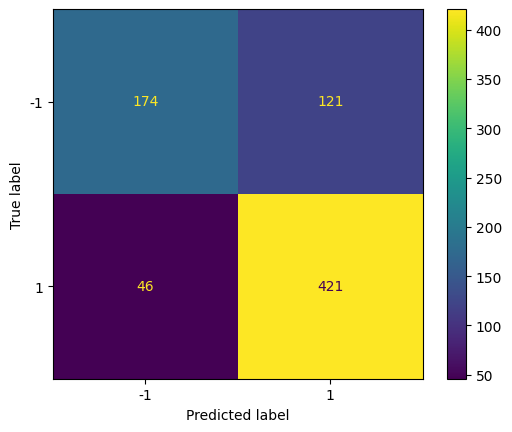

              precision    recall  f1-score   support

          -1       0.79      0.59      0.68       295
           1       0.78      0.90      0.83       467

    accuracy                           0.78       762
   macro avg       0.78      0.75      0.76       762
weighted avg       0.78      0.78      0.77       762

Metrics for rule-based sentiment extraction:

2.5% of extracted Nokia 6600 features/sentiment pairs match ground-truth exactly.
70.4% of extracted Nokia 6600 sentiment-bearing sentences match the ground-truth polarity.

Positive sentiment precision = 0.7.
Positive sentiment recall = 0.76.
Positive sentiment F1-score = 0.73.
Negative sentiment precision = 0.3.
Negative sentiment recall = 0.25.
Negative sentiment F1-score = 0.27.


In [31]:
# display a confusion matrix and other metrics of the ml model using the test set (1 = positive sentiment, -1 = negative sentiment)
print("Confusion matrix for ML model:")
cm = confusion_matrix(test_l, prediction, labels=sentence_clf.classes_)
cm_plt = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentence_clf.classes_)
cm_plt = cm_plt.plot()
plt.grid(False)
plt.show()
print(metrics.classification_report(test_l, prediction))

# displays metrics for the rule-based extraction for the Nokia 6600
print("Metrics for rule-based sentiment extraction:\n")
rule_based_metrics(gt, nokia_sent, file_name)

In [32]:
# used the trained model to predict the general sentiment of each sentence of a given product and returns a dictionary of sentences with sentiment values
def get_ml_sentiments(sentences, model, exclusion_list):
    sentiment_dict = {}
    sentence_lst = []
    for k, v in sentences.items():
        sentence_lst.append([k, process_sentence(v, exclusion_list)])
    sentence_predicted = [s[1] for s in sentence_lst]
    predict = model.predict(sentence_predicted)

    for k, v in zip(sentence_predicted, predict):
        if v == 1:
            sentiment_dict[k] = '+'
        elif v == -1:
            sentiment_dict[k] = '-'
    merge_dict = {}
    sentence_numbers = [k for k in sentences.keys()]
    predicted_dicts_in_list = []
    for k, v in sentiment_dict.items():
        temp = {k: v}
        predicted_dicts_in_list.append(temp)

    for k, v in zip(sentence_numbers, predicted_dicts_in_list):
        merge_dict[k] = v

    return merge_dict

In [33]:
# returns dictionaries of sentiment for each sentence of the four products
nokia_ml_sent_dict = get_ml_sentiments(review_sentences[file_name], sentence_clf, punctuation_list)
nikon_ml_sent_dict = get_ml_sentiments(review_sentences[file_name1], sentence_clf, punctuation_list)
canon_ml_sent_dict = get_ml_sentiments(review_sentences[file_name2], sentence_clf, punctuation_list)
ipod_ml_sent_dict = get_ml_sentiments(review_sentences[file_name3], sentence_clf, punctuation_list)
# shows the ml-derived sentiment for each sentence of the Nokia 6600 reviews
print(nokia_ml_sent_dict)

{1: {"'ve have this beauty for nearly 2 month now and truely love": '+'}, 2: {'the only disappointment so far have be battery life': '+'}, 3: {'mine generally require a charege every 48 hour or so and do not really talk on that much': '+'}, 4: {'why be this phone so great': '+'}, 5: {'simple': '+'}, 6: {'have': '+'}, 7: {'be the first phone know of have the large bright screen infrared bluetooth usb connector and a speakerphone': '+'}, 8: {'if be look for an upgrade be definitely the phone for': '+'}, 10: {'get with the need for a nokia gsm camera phone with speakerphone': '+'}, 11: {'3660 have similar feature but be big in size': '+'}, 12: {'6600 look and feel nice': '+'}, 13: {'this one be full of features(has bluetooth': '+'}, 14: {'especially the lcd be big and the camera quality be among the very good around': '+'}, 15: {'have set up be pda feature with avantgo.com where can download info from site like weather mapquest map direction into be great': '+'}, 16: {'use supply s w can 

In [34]:
# finds any extracted features in sentences, and assigns the sentence sentiment from the ml model to that feature. Returns a dictionary of matches
def assign_ml_features(feature_list, ml_sent_dictionary):
    matched_feature_sentiment = {}
    for outer_key, inner_dict in ml_sent_dictionary.items():
        for inner_key, v in inner_dict.items():
            for f in feature_list:
                if check_for_feature(f, inner_key):
                    matched_feature_sentiment[outer_key] = {f: v}

    return matched_feature_sentiment

In [35]:
# returns dictionaries in the same format as the rule-based and ground-truth data for each of the four products
nokia_ml_feature_sentiment = assign_ml_features(nokia_chunky, nokia_ml_sent_dict)
nikon_ml_feature_sentiment = assign_ml_features(nikon_chunky, nikon_ml_sent_dict)
canon_ml_feature_sentiment = assign_ml_features(canon_chunky, canon_ml_sent_dict)
ipod_ml_feature_sentiment = assign_ml_features(ipod_chunky, ipod_ml_sent_dict)
# shows the features and associated sentiments from the ML model for the Nokia 6600
print(nokia_ml_feature_sentiment)

{1: {'love': '+'}, 2: {'battery': '+'}, 3: {'minute': '+'}, 4: {'phone': '+'}, 7: {'connection': '+'}, 8: {'phone': '+'}, 10: {'phone': '+'}, 11: {'size': '+'}, 12: {'hand': '+'}, 13: {'bluetooth': '+'}, 14: {'good': '+'}, 15: {'direction': '+'}, 16: {'user': '+'}, 17: {'day': '-'}, 19: {'nokia': '+'}, 20: {'phone': '+'}, 21: {'piece': '+'}, 22: {'phone': '+'}, 23: {'user': '+'}, 24: {'hand': '+'}, 25: {'good': '+'}, 26: {'hand': '+'}, 27: {'cell phone': '-'}, 28: {'good': '+'}, 29: {'look': '+'}, 30: {'complaint': '-'}, 31: {'good': '+'}, 32: {'nokia': '+'}, 33: {'while': '+'}, 34: {'mmc card': '+'}, 35: {'video': '-'}, 36: {'problem': '+'}, 37: {'build': '+'}, 38: {'phone': '+'}, 39: {'good': '+'}, 40: {'car': '+'}, 41: {'phone': '+'}, 42: {'phone': '+'}, 43: {'hand': '+'}, 44: {'hand': '+'}, 45: {'user': '+'}, 46: {'functionality': '+'}, 48: {'net': '+'}, 49: {'net': '+'}, 50: {'way': '-'}, 51: {'while': '+'}, 52: {'life': '-'}, 53: {'good': '+'}, 54: {'user': '+'}, 55: {'video': '+

In [36]:
# creates a dictionary of features and the total positive or negative reviews of that feature
def create_product_summary(sentiment_dict, product):
    feature_dict = {product: {}}
    for key in sentiment_dict.keys():
        for k, v in sentiment_dict[key].items():
            if k not in feature_dict[product].keys():
                feature_dict[product].update({k: {'positive': 0, 'negative': 0}})
            if v == '+':
                feature_dict[product][k]['positive'] += 1
            elif v == '-':
                feature_dict[product][k]['negative'] += 1

    return feature_dict

In [37]:
# collated features and sentiment for the given products for the rule-based extraction, ground-truth, and ml-extraction, respectively.
nokia_file_summary = create_product_summary(nokia_sent, file_name)
nokia_gt_summary = create_product_summary(gt[file_name], file_name)
nokia_ml_summary = create_product_summary(nokia_ml_feature_sentiment, file_name)

nikon_file_summary = create_product_summary(nikon_sent, file_name1)
nikon_gt_summary = create_product_summary(gt[file_name1], file_name1)
nikon_ml_summary = create_product_summary(nikon_ml_feature_sentiment, file_name1)

canon_file_summary = create_product_summary(canon_sent, file_name2)
canon_gt_summary = create_product_summary(gt[file_name2], file_name2)
canon_ml_summary = create_product_summary(canon_ml_feature_sentiment, file_name2)

ipod_file_summary = create_product_summary(ipod_sent, file_name3)
ipod_gt_summary = create_product_summary(gt[file_name3], file_name3)
ipod_ml_summary = create_product_summary(ipod_ml_feature_sentiment, file_name3)

# shows the ML-derived collated sentiment data for each feature of the Nokia 6600
print(nokia_ml_summary)

{'Nokia 6600': {'love': {'positive': 11, 'negative': 0}, 'battery': {'positive': 3, 'negative': 0}, 'minute': {'positive': 3, 'negative': 2}, 'phone': {'positive': 43, 'negative': 6}, 'connection': {'positive': 4, 'negative': 1}, 'size': {'positive': 1, 'negative': 0}, 'hand': {'positive': 64, 'negative': 22}, 'bluetooth': {'positive': 3, 'negative': 0}, 'good': {'positive': 43, 'negative': 0}, 'direction': {'positive': 1, 'negative': 0}, 'user': {'positive': 43, 'negative': 11}, 'day': {'positive': 0, 'negative': 1}, 'nokia': {'positive': 10, 'negative': 0}, 'piece': {'positive': 6, 'negative': 0}, 'cell phone': {'positive': 5, 'negative': 1}, 'look': {'positive': 2, 'negative': 0}, 'complaint': {'positive': 0, 'negative': 2}, 'while': {'positive': 7, 'negative': 8}, 'mmc card': {'positive': 2, 'negative': 1}, 'video': {'positive': 7, 'negative': 3}, 'problem': {'positive': 6, 'negative': 6}, 'build': {'positive': 2, 'negative': 0}, 'car': {'positive': 2, 'negative': 0}, 'functionalit

In [38]:
# plots a horizontal bar chart to display the top features and their sentiment. Number of features displayed defined by 'n_prods' variable.
warnings.filterwarnings("ignore")

def display_results(summary_dict, ground_truth_dict, ml_dict, num_prods):
    plt.style.use('seaborn')
    title = ''
    features = None
    prod = None
    # ingest and organise data for pipeline-extracted sentiments
    for key in summary_dict.keys():
        title = f'Top {num_prods} rule-based ' + key.lower() + ' features'
        prod = key
        features = [f for f in summary_dict[key].keys()]
    review_counts = {}
    for item in features:
        review_counts[item] = (summary_dict[prod][item]['positive'], summary_dict[prod][item]['negative'])
    review_counts_sorted = {k: v for k, v in sorted(review_counts.items(), key=lambda dic: dic[1])}
    count_record = []
    for k, v in review_counts_sorted.items():
        count = v[0] + v[1]
        count_record.append([k, count])

    # ingest and organise data for the ground-truth sentiments
    title_gt = ''
    features_gt = None
    for key in ground_truth_dict.keys():
        title_gt = f'Top {num_prods} ground-truth ' + key.lower() + ' features'
        features_gt = [f for f in ground_truth_dict[key].keys()]
    review_counts_gt = {}
    for item in features_gt:
        review_counts_gt[item] = (ground_truth_dict[prod][item]['positive'], ground_truth_dict[prod][item]['negative'])
    review_counts_sorted_gt = {k: v for k, v in sorted(review_counts_gt.items(), key=lambda dic: dic[1])}
    count_record_gt = []
    for k, v in review_counts_sorted_gt.items():
        count = v[0] + v[1]
        count_record_gt.append([k, count])

    # ingest and organise data for the ml-derived sentiments
    title_ml = ''
    features_ml = None
    for key in ml_dict.keys():
        title_ml = f'Top {num_prods} ml-derived ' + key.lower() + ' features'
        features_ml = [f for f in ml_dict[key].keys()]
    review_counts_ml = {}
    for item in features_ml:
        review_counts_ml[item] = (ml_dict[prod][item]['positive'], ml_dict[prod][item]['negative'])
    review_counts_sorted_ml = {k: v for k, v in sorted(review_counts_ml.items(), key=lambda dic: dic[1])}
    count_record_ml = []
    for k, v in review_counts_sorted_ml.items():
        count = v[0] + v[1]
        count_record_ml.append([k, count])

    # sort out the top 10 features for each dataset
    sorted_lst = sorted(count_record, key=lambda x: x[1], reverse=True)
    sorted_lst = sorted_lst[:num_prods]
    top_features = [f[0] for f in sorted_lst]

    sorted_lst_gt = sorted(count_record_gt, key=lambda x: x[1], reverse=True)
    sorted_lst_gt = sorted_lst_gt[:num_prods]
    top_features_gt = [f[0] for f in sorted_lst_gt]

    sorted_lst_ml = sorted(count_record_ml, key=lambda x: x[1], reverse=True)
    sorted_lst_ml = sorted_lst_ml[:num_prods]
    top_features_ml = [f[0] for f in sorted_lst_ml]

    # plot two subplots to compare the ground-truth with the extracted feature sentiments
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for i, feature in enumerate(top_features):
        positive, negative = review_counts_sorted[feature]

        bar1 = ax[0].barh(feature, positive, height=0.5, color='b', label='Positive')
        bar2 = ax[0].barh(feature, negative, height=0.5, color='r', left=positive, label='Negative')

    for i, feature in enumerate(top_features_gt):
        positive, negative = review_counts_sorted_gt[feature]

        bar1 = ax[1].barh(feature, positive, height=0.5, color='b', label='Positive')
        bar2 = ax[1].barh(feature, negative, height=0.5, color='r', left=positive, label='Negative')

    for i, feature in enumerate(top_features_ml):
        positive, negative = review_counts_sorted_ml[feature]

        bar1 = ax[2].barh(feature, positive, height=0.5, color='b', label='Positive')
        bar2 = ax[2].barh(feature, negative, height=0.5, color='r', left=positive, label='Negative')

    handles = [bar1, bar2]
    ax[0].set_yticklabels(top_features)
    ax[0].legend(handles=handles)
    ax[0].set_title(title)
    ax[0].set_xlabel('Total sentiment count')

    ax[1].set_yticklabels(top_features_gt)
    ax[1].legend(handles=handles)
    ax[1].set_title(title_gt)
    ax[1].set_xlabel('Total sentiment count')

    ax[2].set_yticklabels(top_features_ml)
    ax[2].legend(handles=handles)
    ax[2].set_title(title_ml)
    ax[2].set_xlabel('Total sentiment count')

    plt.subplots_adjust(wspace=1, hspace=0.4)

    plt.show()

## Evaluation and Discussion

Below are the results of the opinion miner pipeline for the four products on which the pipeline has been run in its entirety. Each set of three plots shows the top 15 extracted features and their sentiment for three different results. The first in each row is the rule-based sentiment extraction process, while the third plot shows the features and sentiment from the Naive Bayes implementation of the pipeline. Each of these can then be compared to the centre plot from the ground-truth dataset.
It is clear from these plots that, of the two extraction pipelines, the rule-based process has done a marginally better job of finding relevant features than that of the ml model. For example, the Canon PowerShot SD500 extraction shows similar features between the ground-truth and the rule-based features, while a larger proportion of the model-based features are clearly not features being discussed in the reviews (e.g. 'one' and 'hand'). A similar result can be seen in the other three products, although not as starkly as that of the Canon. This is likely a result of the difference in the way features and sentiment are matched between the two processes. While both use the same process to extract a list of potential features from the sentences, the rule-based approach further reduces this list by removing those features that do not have related sentiment-bearing adjectives. In contrast, the ml model uses the feature list and assigns each feature present in a sentence to the sentiment derived by the model for that sentence, thus skipping the process of further reducing the feature list. It might be that in future a hybrid of the two processes would work better, whereby features are reduced by the presence of adjectives but are still assigned the sentiment trained by the model. A second improvement, one which would avoid clear errors like the feature 'one', would be to loop through each word in the sentence to check that it matches the feature, rather than simply looking for the presence of the word in the sentence.
##### Further work
While the rule-based process has mostly identified relevant features when compared to the ground-truth, there are generally less total reviews of each than the ground-truth set. This is likely the result of differing word usage used to describe the same feature, the recognition of which was not incorporated into the pipeline. This could be alleviated somewhat by checking for synonyms within each sentence in a more effective way than was attempted thus far. Furthermore, the occasions of inferred sentiment on a given product in a complex sentence will have been difficult for the pipeline to extract and will have further reduced the efficacy of the extraction of these features.

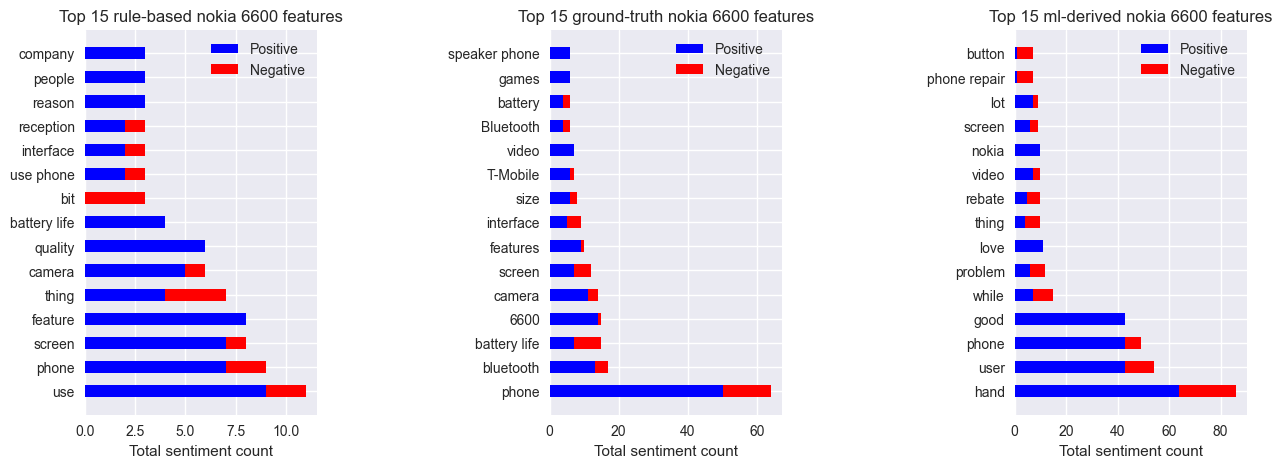

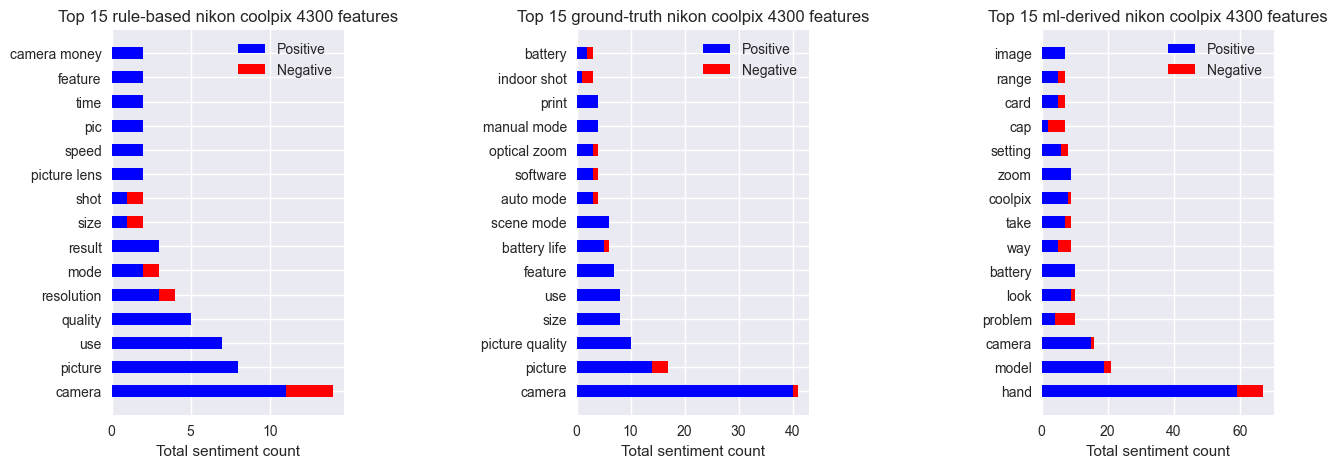

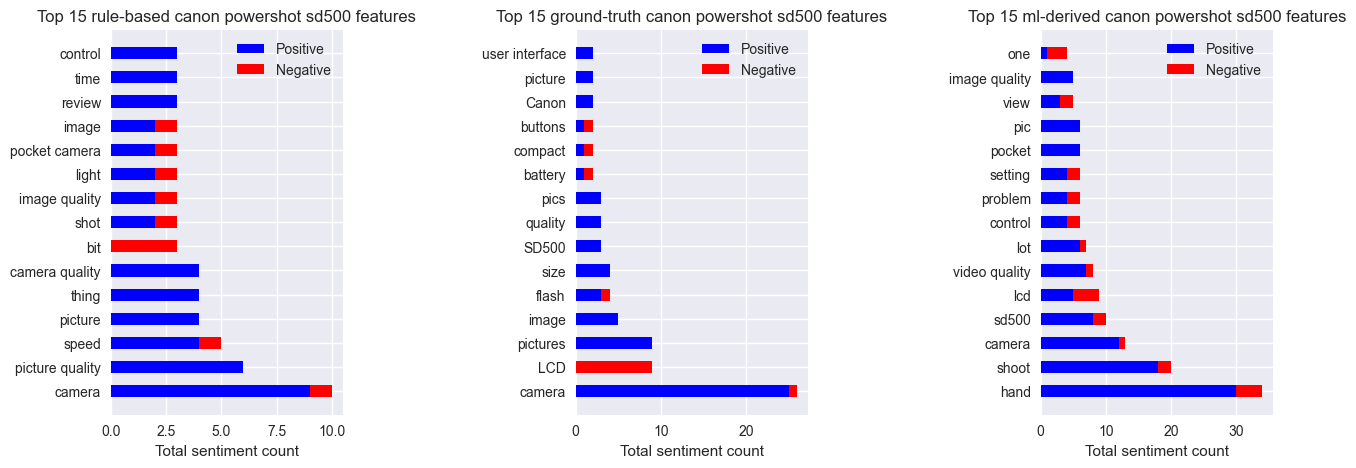

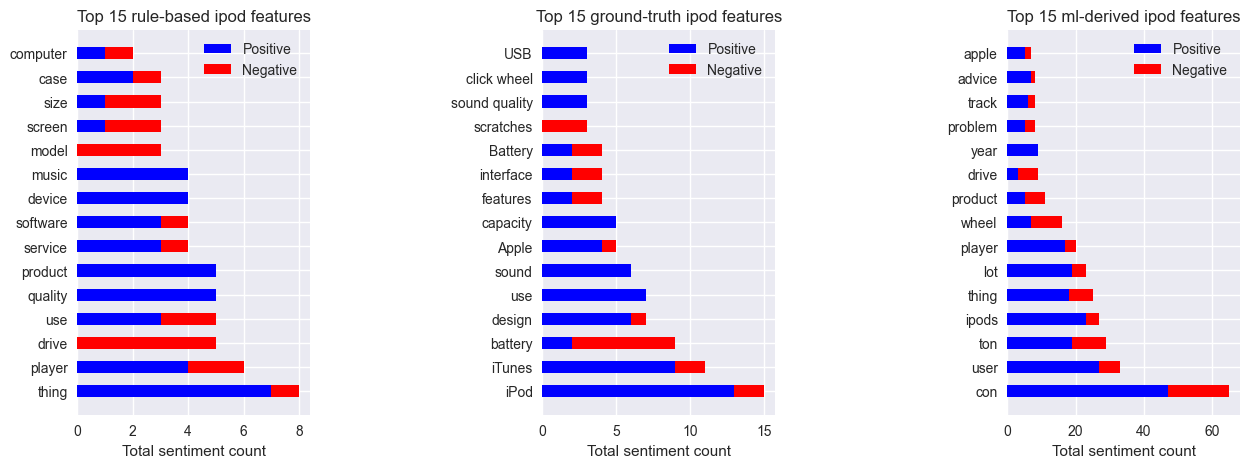

In [39]:
# displays results for the Nokia 6600
display_results(nokia_file_summary, nokia_gt_summary, nokia_ml_summary, 15)
# displays results for the Nikon Coolpix 4300
display_results(nikon_file_summary, nikon_gt_summary, nikon_ml_summary, 15)
# displays results for the Canon PowerShot SD500
display_results(canon_file_summary, canon_gt_summary, canon_ml_summary, 15)
# displays results for the iPod
display_results(ipod_file_summary, ipod_gt_summary, ipod_ml_summary, 15)

## References
Bird, S., Klein, E. and Loper E., 2009. Natural language processing with Python. O'Reilly Media, Inc. ISBN: 978-0-596-51649-9.
Hu, M. and Liu, B., 2004a. Mining and Summarizing Customer Reviews. *Proceedings of the Tenth ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*. pp.167–177.
Hu, M. and Liu, B., 2004b. Mining Opinion Features in Customer Reviews. *American Association for Artificial Intelligence*, 4(4), pp.755–760. Available from: www.aaai.org.
Kochmar, E., 2021. Getting started with natural language processing. Manning Publications, ISBN: 9781617296765.
Liu, Q., Gao, Z., Liu, B. and Zhang, Y., 2015. Automated Rule Selection for Aspect Extraction in Opinion Mining. *Proceedings of the Twenty-Fourth International Joint Conference on Artificial Intelligence*. pp.1291–1297.
Su, Q., Xiang, K., Wang, H. and Yu, S., 2006. Using Pointwise Mutual Information to Identify Implicit Features in Customer Reviews. In: Y. Matsumoto, R.W. Sproat, K.F. Wong and M. Zhang, eds. *Computer Processing of Oriental Languages. Beyond the Orient: The Research Challenges Ahead*, 4285. Berlin: Springer, pp.22–30.


### Library versions used in this project
##### Includes all dependency libraries

blis==0.7.9
catalogue==2.0.8
certifi==2022.12.7
charset-normalizer==2.1.1
click==8.1.3
colorama==0.4.6
confection==0.0.3
cycler==0.11.0
cymem==2.0.7
idna==3.4
jinja2==3.1.2
joblib==1.2.0
kiwisolver==1.4.4
langcodes==3.3.0
markupsafe==2.1.1
matplotlib==3.4.3
murmurhash==1.0.9
nltk==3.6.5
numpy==1.24.0
packaging==22.0
pathy==0.10.1
pillow==9.3.0
preshed==3.0.8
pydantic==1.10.2
pyparsing==3.0.9
python-dateutil==2.8.2
regex==2022.10.31
requests==2.28.1
scikit-learn==1.2.0
scipy==1.9.3
six==1.16.0
smart-open==6.3.0
spacy==3.4.4
spacy-legacy==3.0.10
spacy-loggers==1.0.4
srsly==2.4.5
textblob==0.15.3
thinc==8.1.6
threadpoolctl==3.1.0
tqdm==4.64.1
typer==0.7.0
typing-extensions==4.4.0
urllib3==1.26.13
vadersentiment==3.3.2
wasabi==0.10.1